
# Intial setup

Angela M. Rojas A. <angelara@student.unimelb.edu.au>

Created on 08 Sep 2020

This notebook uses historic data on GHG emissions, wholesale prices and tariffs to validate simulation results for this outputs using certain input settings. 
The validation is performed with available data from the official start of the easter market in Australia in 1999.
Data sources, wrangling exercises and assumptions are commented throughout the notebook.

In [4]:
import sys
import os

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments\EMAworkbench')

sys.path.append(r'C:\Users\angel\Documents\GitHub\gr4sp\experiments')

import statistics
import datetime as DT
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.dates as mdates
import seaborn as sns

import os
import glob
import numpy as np
import pandas as pd
import os
import glob



## Load BAU results
The model has two types of results reporting: Full and Light. It also provide results summarised by month and by year. Their used will depend on the type of validation. For instance, wholesale prices can be found in a monthly basis since April 2005. Therefore, monthly results on simulated wholesale prices are used in this case. Even though emissions can be reported for every month (and even every 30 min if needed), greenhouse gas emissions are usually presented in a yearly basis therefore, if further granularity is not needed, annual simulations results are used in this case.

NB! files for BAU to make validation should have the same seed.


In [991]:
# load ligth report - yearly and monthly summary
yearly_bau_results_df = pd.read_csv(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/VICSimDataYearSummary_seed_1600242677434.csv', index_col='Time (Year)')
monthly_bau_results_df = pd.read_csv(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/VICSimDataMonthlySummary_seed_1600242677434.csv', index_col='Time (Month)')


In [992]:
yearly_bau_results_df.head()

,Consumption (KWh) per household,Avg Tariff (c/KWh) per household,Wholesale ($/MWh),GHG Emissions (tCO2-e) per household,Number of Domestic Consumers (households),Percentage Renewable Production,System Production Primary Spot,System Production Secondary Spot,System Production Off Spot,System Production Rooftop PV,...,285000 - Battery - Gannawarra Energy Storage System - 25.33 - S - 2020 - 2033 - OffSpot,293000 - Wind - Berrybank Wind Farm - 180.6 - SS - 2020 - 2050 - Primary,295000 - Wind - Moorabool Wind Farm - 320.32 - SS - 2020 - 2044 - Primary,297000 - Wind - Stockyard Hill Wind Farm - 531.93 - SS - 2020 - 2045 - Primary,301000 - Wind - Cherry Tree Wind Farm - 57.6 - SS - 2020 - 2050 - Primary,303000 - Solar - Carwarp Solar Farm - Stage I - 100.0 - SS - 2020 - 2050 - Primary,305000 - Wind - Dundonnell Wind Farm - 336.0 - SS - 2020 - 2045 - Primary,308000 - Wind - Mortlake South Wind Farm - 157.5 - SS - 2020 - 2050 - Primary,317000 - Solar - Winton Asset Co. Pty Ltd as Trustee of the Winton Asset Trust - 85.0 - SS - 2021 - 2051 - Primary,331000 - Solar - Kiamal Solar Farm - Stage 2 - 149.96 - SS - 2022 - 2052 - Primary
Time (Year),,,,,,,,,,,,,,,,,,,,,
1998,7276.042544,29.583000,0.000000,8.424717,1664516.0,0.000000,0.000000e+00,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999,7974.262078,29.736000,9.971649,9.761047,1692608.0,0.032008,2.322111e+07,0.0,269535.750000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000,8340.115992,30.320848,23.956673,10.620494,1721565.0,0.043711,4.695003e+07,0.0,536263.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001,8226.440058,18.416590,23.606718,10.441529,1751669.0,0.042532,4.694617e+07,0.0,683435.920000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2002,8193.844584,17.348118,23.943001,10.327522,1780468.0,0.052457,4.743421e+07,0.0,843596.915231,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [993]:
""" Filtering GHG emissions from BAU """

data_GHG_household = yearly_bau_results_df['GHG Emissions (tCO2-e) per household']

""" Converts household data in tCO2e into total residential data in MtCO2e"""
data_GHG_residential = (data_GHG_household * yearly_bau_results_df['Number of Domestic Consumers (households)']) / 1000000.0

""" Applies scaling factor used in simulation, so that data represents total emissions, not only residential (30%)"""
data_GHG_total = data_GHG_residential / 0.3

data_GHG_total_df =  pd.DataFrame(data_GHG_total)

# Since the market started officially in 1999, it is assumed that quantification of emissions stabilises after this date.
# Therefore, the years 1998 and 1999 are ignored.

simul_data_GHG_total_df=data_GHG_total_df.rename(columns = {0:'Simulated_GHGE_VIC (MtCO2e)'})[2:]
simul_data_GHG_total_df.head()


,Simulated_GHGE_VIC (MtCO2e)
Time (Year),
2000,60.946239
2001,60.967012
2002,61.292742
2003,62.389799
2004,63.260981


## GHG emissions validation
1. load historic emissions and merge with simulated results
2. plot historic and simulated results
3. use a descriptive statistic measure to validate results from simulation against historic values

The key role of decarbonising the electricity sector in Victoria: The electricity sector in Victoria accounted for more than half of emissions in 2016. After the retirement of Hazelwood, this contribution still sited at 42% of the state's emissions. At the validation date (2020), historic emissions data for the electricity sector in Victoria is only available until 2017. 2018 number has been assumed to be 2017 (56.1) value minus a net reduction of 11.8 MtCO2-e given the retirement of Hazelwood in 2017.
Sources of data:
- https://engage.vic.gov.au/climate-change-reducing-victorias-greenhouse-gas-emissions
- https://www.climatechange.vic.gov.au/information-and-resources/greenhouse-gas-emissions-in-victoria
- https://www.climatechange.vic.gov.au/__data/assets/pdf_file/0033/395079/Victorian-Greenhouse-Gas-Emissions-Report-2018.pdf
- https://www.climatechange.vic.gov.au/__data/assets/pdf_file/0016/443014/Victorian-Greenhouse-Gas-Emissions-Report-2019.pdf

### load historic emissions and merge with simulation results


In [994]:
#A CSV is built based on the information available in these sources 
historic_emissions_df = pd.read_csv(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/19902018_historic_emissions_Vic.csv', index_col='Time (Year)')

In [995]:
historic_emissions_df.head()

,Hist_GHGE_MtCO2e
Time (Year),
1990,44.2
1991,46.3
1992,47.5
1993,45.3
1994,45.5


In [996]:
from functools import reduce

historic_and_simul_emissions_list = [simul_data_GHG_total_df, historic_emissions_df]
historic_and_simul_emissions_list

historic_and_simul_emissions_df = reduce(lambda x, y: pd.merge(x, y, on = 'Time (Year)'), historic_and_simul_emissions_list)
historic_and_simul_emissions_df.head()

,Simulated_GHGE_VIC (MtCO2e),Hist_GHGE_MtCO2e
Time (Year),,
2000,60.946239,62.7
2001,60.967012,62.2
2002,61.292742,60.4
2003,62.389799,61.5
2004,63.260981,64.7


### Plot historic and simulated emissions

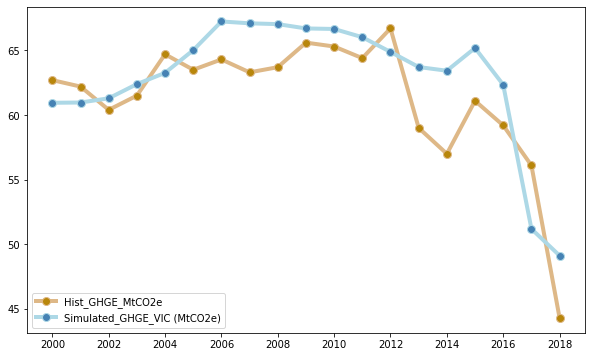

In [997]:
plt.figure(figsize=(10,6))
#xfmt = mdates.DateFormatter('%Y-%m-%d')
#axes.xaxis.set_major_formatter(xfmt)


yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in historic_and_simul_emissions_df.index]

plt.plot( yearly_dates, 'Hist_GHGE_MtCO2e', data=historic_and_simul_emissions_df, marker='o', markerfacecolor='darkgoldenrod', markersize=8, color='burlywood', linewidth=4)
plt.plot( yearly_dates,'Simulated_GHGE_VIC (MtCO2e)', data=historic_and_simul_emissions_df, marker='o', markerfacecolor='steelblue', markersize=8, color='lightblue', linewidth=4)

plt.legend()


### Validation using MAD

The validation uses the [Median Absolute Deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation) between historic emissions and simulation results. The validation is done for the years 2000 to 2018. 
$b$ is 1.4826 and it is a constant linked to assumption of normality of the data (i.e. disregarding the abnormality of the data) [(Leys et al, 2013)
](http://dx.doi.org/10.1016/j.jesp.2013.03.013) and can be used to find the standard deviation. 

The MAD used here is an adaptation in which the statistic is used to compare historic and simulated results.
$MAD = median (|s_i - h_i|)$, where $i$ is the year of analysis, $s_i$ is the simulated emissions and $h_i$ is the historic data point at the $i_{th}$ year.

In [998]:
b = 1.4826

abs_difference_list = list()
for i in historic_and_simul_emissions_df.index:
    diff = abs(historic_and_simul_emissions_df.loc[i][0] - historic_and_simul_emissions_df.loc[i][1])
    abs_difference_list.append(diff)

mad = statistics.median(abs_difference_list)
std = mad*b
print(f"Simulated results are {mad.round(decimals=2)} MTCO2-e (MAD) away from historic data")
print(f"Simulated results have a standard deviation of {std.round(decimals=2)} MTCO2-e from historic data")
  

Simulated results are 1.82 MTCO2-e (MAD) away from historic data
Simulated results have a standard deviation of 2.7 MTCO2-e from historic data


### Validation with Percentage difference

In [999]:
simulated_emissions = historic_and_simul_emissions_df.iloc[:,0]
historic_emissions = historic_and_simul_emissions_df.iloc[:,1]

diff = np.maximum(simulated_emissions,historic_emissions) / np.minimum(simulated_emissions,historic_emissions) - 1.0
historic_and_simul_emissions_df['Percentage difference'] = np.where(simulated_emissions<historic_emissions, 
                                                                    diff, 
                                                                    diff * -1.0)

difference_emissions = historic_and_simul_emissions_df['Percentage difference']*100

average_percentage_difference_emissions = difference_emissions.mean()
median_percentage_difference_emissions = difference_emissions.median()
print(f"The average percentage difference of simulated results vs historic data is {average_percentage_difference_emissions} %")
print(f"Simulated results have a median of {median_percentage_difference_emissions} % different from historic data")


The average percentage difference of simulated results vs historic data is -2.629270329598294 %
Simulated results have a median of -2.3914408471752635 % different from historic data


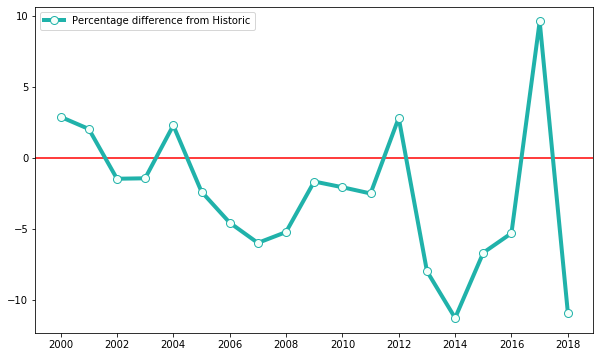

In [1000]:
plt.figure(figsize=(10,6))
#xfmt = mdates.DateFormatter('%Y-%m-%d')
#axes.xaxis.set_major_formatter(xfmt)
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in historic_and_simul_emissions_df.index]

plt.axhline(y=0.0, color='r', linestyle='-')
plt.plot(yearly_dates, difference_emissions, marker='o', 
         markerfacecolor='mintcream', markersize=8, color='lightseagreen', 
         linewidth=4, label='Percentage difference from Historic')

plt.legend()

## Wholesale prices validation

1. load historic and simulated monthly wholesale prices
2. plot historic and simulated results
3. use a descriptive statistic measure to validate results from simulation against historic values

Wholesale data can be found since 2005 in a monthly basis. Therefore, the monthly summary report is used for this validation. 
Sources of data:
- https://opennem.org.au/energy/vic1/

### Load historic and simulated wholesale prices. Merge data.

In [1001]:
historic_wholesale_df = pd.read_csv(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/2005_2020_OpenNemData.csv', index_col='Time (Month)')
historic_wholesale_df.index = pd.to_datetime(historic_wholesale_df.index)

historic_wholesale_df.tail(5)

,Temperature - C,Solar (Rooftop) Market Value - $,Solar (Rooftop) - GWh,Solar (Utility) Market Value - $,Solar (Utility) - GWh,Wind Market Value - $,Wind - GWh,Hydro Market Value - $,Hydro - GWh,Battery (Discharging) Market Value - $,...,Wind Market Value - $/MWh,Hydro Market Value - $/MWh,Battery (Discharging) Market Value - $/MWh,Gas (OCGT) Market Value - $/MWh,Gas (Steam) Market Value - $/MWh,Brown Coal Market Value - $/MWh,Imports Market Value - $/MWh,Exports Market Value - $/MWh,Volume Weighted Price (Historic) - $/MWh,Imports % from wholesale price
Time (Month),,,,,,,,,,,,,,,,,,,,,
2020-02-01,NaN,11046099.38,236.64,3140665.43,63.47,15975882.68,353.60,11175242.19,162.31,89302.87,...,45.180664,68.851224,62.449559,49.450267,77.320239,48.286402,68.996429,-35.581645,49.201480,40%
2020-03-01,NaN,9371047.33,242.25,2161224.14,54.89,20202458.31,509.42,5708287.32,93.76,80608.03,...,39.657764,60.881904,53.382801,54.960500,52.742213,42.805408,55.120354,-29.094308,43.196436,28%
2020-04-01,NaN,4520912.07,168.84,1122762.58,41.42,11679077.48,450.66,7483478.99,128.86,65057.13,...,25.915496,58.074492,47.142848,63.510072,57.307100,34.549809,55.656262,-16.591142,34.966287,59%
2020-05-01,NaN,4667777.91,150.18,1810744.14,53.65,17358776.22,557.30,19755494.09,380.20,74255.26,...,31.147992,51.960795,51.926755,62.710676,67.015653,38.055585,53.276023,-24.225131,39.152540,36%
2020-06-01,NaN,5207969.50,122.54,1833331.27,41.95,14148801.05,407.59,24841720.39,330.44,186599.67,...,34.713317,75.177704,106.628383,92.794685,121.224747,49.555137,51.449529,-37.553177,51.204533,0%


In [1002]:
""" Filtering whoelsale prices from historic data"""

historic_wholesale_filtered = historic_wholesale_df["Volume Weighted Price (Historic) - $/MWh"]


Load simulation results using BAU settings

In [1003]:
monthly_bau_results_df.head()

,Consumption (KWh) per household,Avg Tariff (c/KWh) per household,Wholesale ($/MWh),GHG Emissions (tCO2-e) per household,Number of Domestic Consumers (households),Percentage Renewable Production,System Production Primary Spot,System Production Secondary Spot,System Production Off Spot,System Production Rooftop PV,...,System Production Battery,Number of Active Actors,Primary Total Unmet Demand (MWh),Primary Total Unmet Demand (Hours),Primary Total Unmet Demand (Days),Primary Max Unmet Demand Per Hour (MWh),Secondary Total Unmet Demand (MWh),Secondary Total Unmet Demand (Hours),Secondary Total Unmet Demand (Days),Secondary Max Unmet Demand Per Hour (MWh)
Time (Month),,,,,,,,,,,,,,,,,,,,,
1998-01-01,610.359253,29.583,0.0,0.708750,1637203.0,0.0,0.0,0.0,0.0,0.0,...,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998-02-01,626.027788,29.583,0.0,0.726945,1639686.0,0.0,0.0,0.0,0.0,0.0,...,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998-03-01,612.804772,29.583,0.0,0.711590,1642169.0,0.0,0.0,0.0,0.0,0.0,...,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998-04-01,584.549193,29.583,0.0,0.678780,1644652.0,0.0,0.0,0.0,0.0,0.0,...,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998-05-01,607.054067,29.583,0.0,0.704912,1647135.0,0.0,0.0,0.0,0.0,0.0,...,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1004]:
# Historic is only available from April 2005 until June 2020. Simulated data for those dates are used for validation.

""" Filtering Whoelsale prices from simulation BAU """

simul_data_wholesale_filtered = monthly_bau_results_df['Wholesale ($/MWh)']
simul_data_wholesale_filtered.index = pd.to_datetime(simul_data_wholesale_filtered.index)


In [1005]:
from functools import reduce

historic_wholesale_list = [historic_wholesale_filtered, simul_data_wholesale_filtered]
historic_wholesale_list

historic_and_simul_wholesale_df = reduce(lambda x, y: pd.merge(x, y, on = 'Time (Month)'), historic_wholesale_list)
historic_and_simul_wholesale_df.head()

,Volume Weighted Price (Historic) - $/MWh,Wholesale ($/MWh)
Time (Month),,
2005-04-01,31.809904,32.355247
2005-05-01,25.330109,67.732674
2005-06-01,24.249596,83.634773
2005-07-01,27.651352,65.896629
2005-08-01,32.022126,65.412201


### Plot historic and simulated wholesale prices

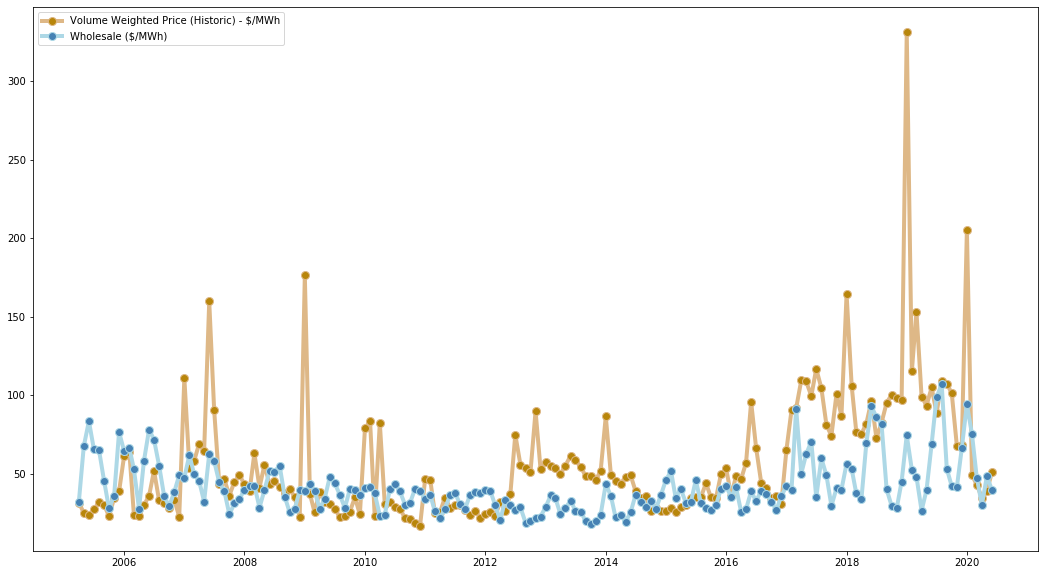

In [1006]:
plt.figure(figsize=(18,10))
plt.plot( 'Volume Weighted Price (Historic) - $/MWh', data=historic_and_simul_wholesale_df, marker='o', markerfacecolor='darkgoldenrod', markersize=8, color='burlywood', linewidth=4)
plt.plot( 'Wholesale ($/MWh)', data=historic_and_simul_wholesale_df, marker='o', markerfacecolor='steelblue', markersize=8, color='lightblue', linewidth=4)

plt.legend()


### Validation using MAD

In [1007]:
b = 1.4826

abs_difference_list = list()
for i in historic_and_simul_wholesale_df.index:
    diff = abs(historic_and_simul_wholesale_df.loc[i][0] - historic_and_simul_wholesale_df.loc[i][1])
    abs_difference_list.append(diff)

mad = statistics.median(abs_difference_list)
std = mad*b
print(f"Simulated results are {mad.round(decimals=2)} $/MWh (MAD) away from historic data")
print(f"Simulated results have a standard deviation of {std.round(decimals=2)} $/MWh from historic data")

Simulated results are 14.82 $/MWh (MAD) away from historic data
Simulated results have a standard deviation of 21.98 $/MWh from historic data


### Validation with Percentage difference

In [1008]:
simulated_wholesale = historic_and_simul_wholesale_df.iloc[:,0]
historic_wholesale = historic_and_simul_wholesale_df.iloc[:,1]

diff = np.maximum(simulated_wholesale,historic_wholesale) / np.minimum(simulated_wholesale,historic_wholesale) - 1.0
historic_and_simul_wholesale_df['Difference'] = np.where(simulated_wholesale<historic_wholesale, 
                                                                    diff, 
                                                                    diff * -1.0)

difference_wholesale = historic_and_simul_wholesale_df['Difference']*100

average_difference = difference_wholesale.mean()
median_difference = difference_wholesale.median()
print(f"The average difference of simulated results vs historic data is {average_difference} %")
print(f"Simulated results have a median of {median_difference} % different from historic data")



The average difference of simulated results vs historic data is -34.14137295855771 %
Simulated results have a median of -16.94417176509009 % different from historic data


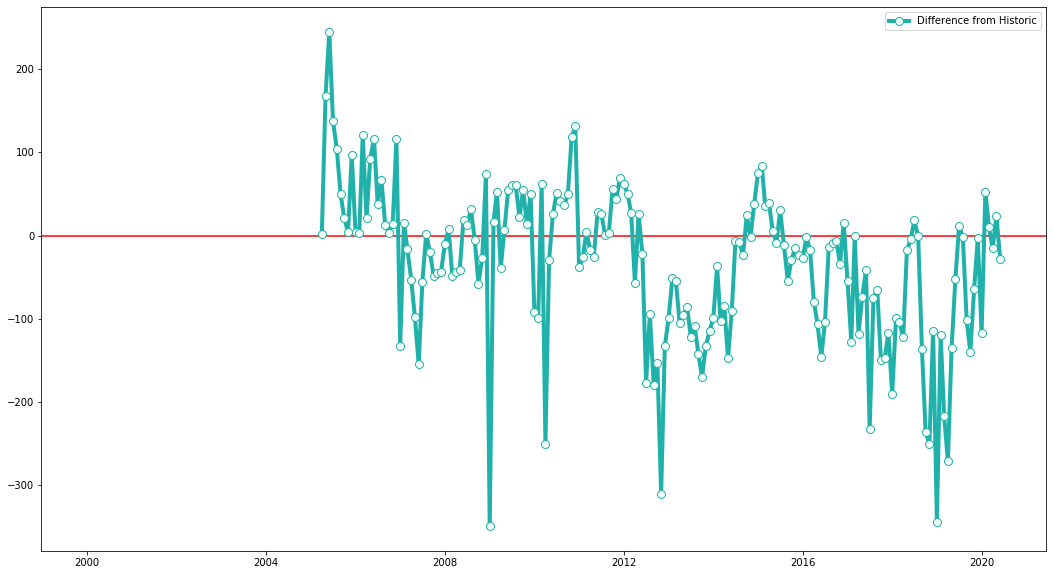

In [1009]:
plt.figure(figsize=(18,10))
#xfmt = mdates.DateFormatter('%Y-%m-%d')
#axes.xaxis.set_major_formatter(xfmt)

plt.axhline(y=0.0, color='r', linestyle='-')
plt.plot( difference_wholesale, marker='o', 
         markerfacecolor='mintcream', markersize=8, color='lightseagreen', 
         linewidth=4, label='Difference from Historic')


plt.legend()

## Tariffs Validation

1. load historic and simulated yearly average tariffs
2. plot historic and simulated results
3. use a descriptive statistic measure to validate results from simulation against historic values

Different sources where used to construct a historic dataset of average electricity tariffs.
- Historic data found in the [ACCC report](https://www.accc.gov.au/system/files/Victorian%20Electricity%20Distribution%20Networks.pdf) from 2017. This data is from a household in VIC that use 4000 KWh/year, has gas water heating. The report has data for the years 1995, 2001, 2002, and from 2007 to 2017. But data is used from 2001. Since the data is given as total bill per year in /$, the price per KWh is computed as (AnnualBill/4000KWh)*100, to get the value in c/kWh.
- [St. Vinnies historic data](https://www.vinnies.org.au/page/Our_Impact/Incomes_Support_Cost_of_Living/Energy/VIC/) on tariffs per retailer and distribution area. This data has been collected since 2010, every quarter of the year. I used the ‘first block’ charges to calculate the average charge of usage in c/KWh. 

Prices from the reports and data sources are adjusted to 2019 values as simulatied tariffs are presented in real terms for the base year of 2019.


### Load and merge historic and simulated tariff data

In [1010]:
# simulated average tariffs in c/kWh (real 2019) filtered from BAU file
yearly_bau_results_tariffs_df = yearly_bau_results_df['Avg Tariff (c/KWh) per household']


In [1011]:
# historic average tariffs in c/kWh (real 2019) filtered from reports
yearly_historic_tariffs = pd.read_csv(r'C:/Users/angel/Documents/GitHub/gr4sp/experiments/simulationData/2001to2019_historicTariffs.csv', index_col='Time (Year)')

In [1012]:
from functools import reduce


historic_and_simul_tariff_list = [yearly_bau_results_tariffs_df, yearly_historic_tariffs]
historic_and_simul_tariff_list

historic_and_simul_tariff_df = reduce(lambda x, y: pd.merge(x, y, on = 'Time (Year)'), historic_and_simul_tariff_list)
historic_and_simul_tariff_df.head()

,Avg Tariff (c/KWh) per household,St Vinnies Historic c/kWh (2019),Historic price from review c/KWh (2019)
Time (Year),,,
2001,18.416590,NaN,27.31
2002,17.348118,NaN,27.01
2003,16.387905,NaN,NaN
2004,17.205383,NaN,NaN
2005,17.644021,NaN,NaN


### Plot historic and simulated residential tariffs

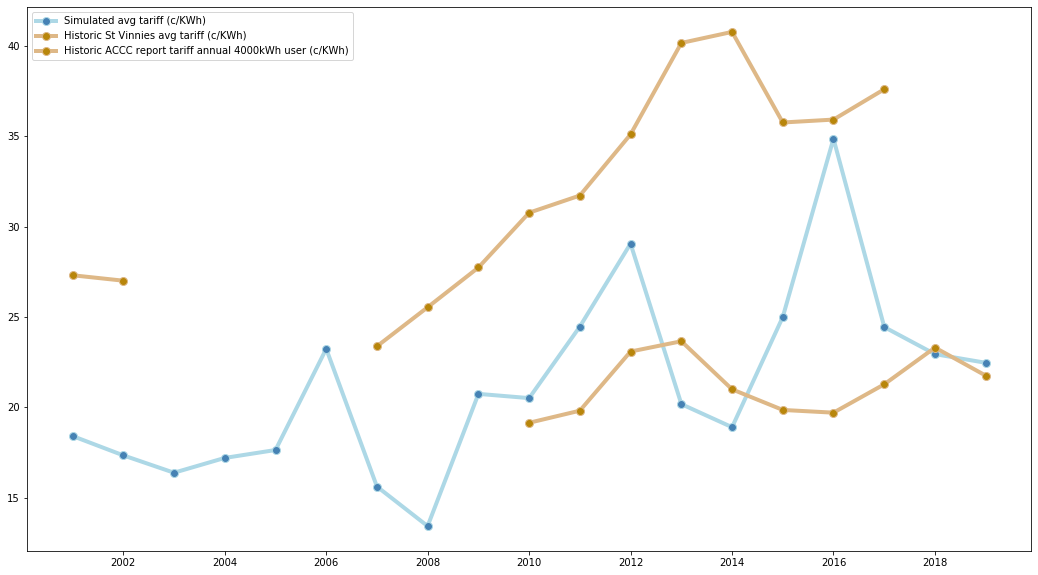

In [1013]:
plt.figure(figsize=(18,10))
data=historic_and_simul_tariff_df
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in historic_and_simul_tariff_df.index]

plt.plot( yearly_dates, data['Avg Tariff (c/KWh) per household'], marker='o', markerfacecolor='steelblue', markersize=8, color='lightblue', linewidth=4, label='Simulated avg tariff (c/KWh)')
plt.plot( yearly_dates, data.iloc[:,1], marker='o', markerfacecolor='darkgoldenrod', markersize=8, color='burlywood', linewidth=4, label='Historic St Vinnies avg tariff (c/KWh)')
plt.plot( yearly_dates, data.iloc[:,2], marker='o', markerfacecolor='darkgoldenrod', markersize=8, color='burlywood', linewidth=4, label='Historic ACCC report tariff annual 4000kWh user (c/KWh)')

plt.legend()


In [1014]:
average_historic = yearly_historic_tariffs.mean(axis=1)
average_historic_df = pd.DataFrame({'Average historic tariff (c/KWh)':average_historic})


In [1015]:
historic_and_simul_tariff_list = [yearly_bau_results_tariffs_df, average_historic_df]
historic_and_simul_tariff_list

average_historic_and_simul_tariff_df = reduce(lambda x, y: pd.merge(x, y, on = 'Time (Year)'), historic_and_simul_tariff_list)
average_historic_and_simul_tariff_df.head(20)

,Avg Tariff (c/KWh) per household,Average historic tariff (c/KWh)
Time (Year),,
2001,18.416590,27.310
2002,17.348118,27.010
2003,16.387905,NaN
2004,17.205383,NaN
2005,17.644021,NaN
2006,23.241417,NaN
2007,15.623156,23.380
2008,13.436048,25.540
2009,20.749136,27.740


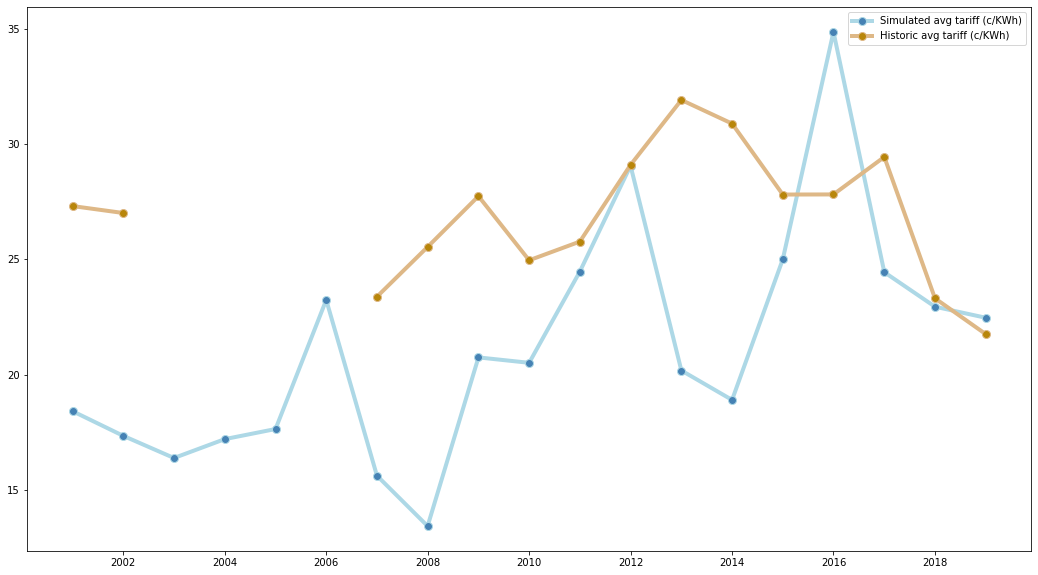

In [1016]:
plt.figure(figsize=(18,10))
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in historic_and_simul_tariff_df.index]
data=average_historic_and_simul_tariff_df
plt.plot( yearly_dates, data['Avg Tariff (c/KWh) per household'], marker='o', markerfacecolor='steelblue', markersize=8, color='lightblue', linewidth=4, label='Simulated avg tariff (c/KWh)')
plt.plot( yearly_dates, data.iloc[:,1], marker='o', markerfacecolor='darkgoldenrod', markersize=8, color='burlywood', linewidth=4, label='Historic avg tariff (c/KWh)')
plt.legend()


### Validation using MAD

In [1017]:
b = 1.4826

abs_difference_list = list()
for i in average_historic_and_simul_tariff_df.index:
    diff = abs(average_historic_and_simul_tariff_df.loc[i][1] - average_historic_and_simul_tariff_df.loc[i][0])
    abs_difference_list.append(diff)

mad = statistics.median(abs_difference_list)
std = mad*b
print(f"Simulated results are {mad.round(decimals=2)} c/KWh (MAD) away from historic data")
print(f"Simulated results have a standard deviation of {std.round(decimals=2)} c/KWh from historic data")

Simulated results are 1.3 c/KWh (MAD) away from historic data
Simulated results have a standard deviation of 1.93 c/KWh from historic data


### Validation with Percentage difference

In [935]:
simulated_tariffs = average_historic_and_simul_tariff_df.iloc[:,0]
historic_tariffs = average_historic_and_simul_tariff_df.iloc[:,1]

diff = np.maximum(simulated_tariffs,historic_tariffs) / np.minimum(simulated_tariffs,historic_tariffs) - 1.0
average_historic_and_simul_tariff_df['Difference'] = np.where(simulated_tariffs<historic_tariffs, 
                                                                    diff, 
                                                                    diff * -1.0)

difference_emissions = average_historic_and_simul_tariff_df['Difference']*100

average_percentage_difference_tariffs = difference_emissions.mean()
median_percentage_difference_tariffs = difference_emissions.median()
print(f"The average percentage difference of simulated results vs historic data is {average_percentage_difference_tariffs} %")
print(f"Simulated results have a median of {median_percentage_difference_tariffs} % different from historic data")



The average percentage difference of simulated results vs historic data is 28.70951964826595 %
Simulated results have a median of 21.666855913618633 % different from historic data


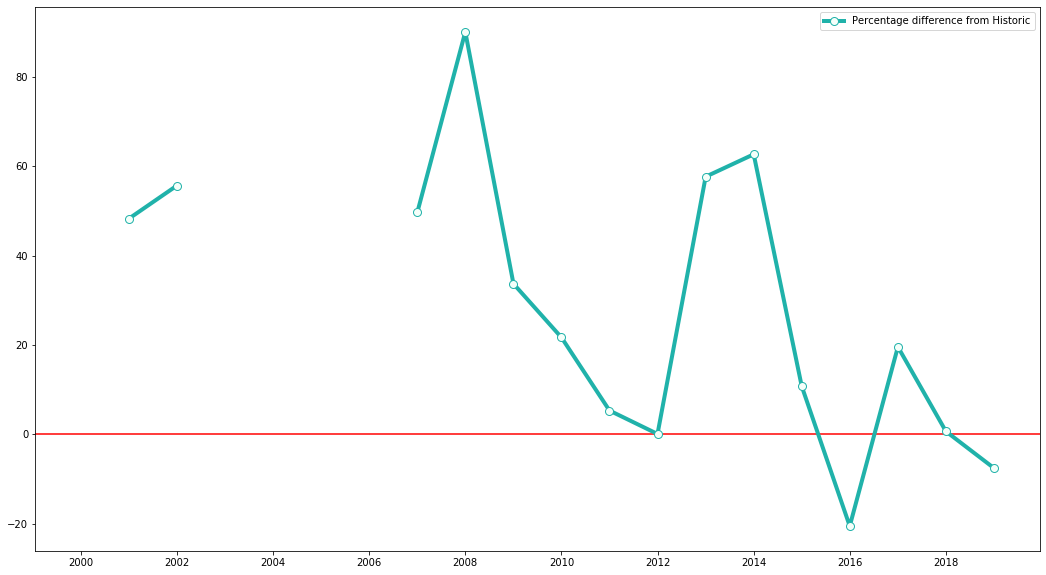

In [936]:
plt.figure(figsize=(18,10))
#xfmt = mdates.DateFormatter('%Y-%m-%d')
#axes.xaxis.set_major_formatter(xfmt)
yearly_dates = [DT.datetime.strptime(str(int(date)),'%Y') for date in historic_and_simul_tariff_df.index]

plt.axhline(y=0.0, color='r', linestyle='-')
plt.plot( yearly_dates, percentage_difference_tariffs, marker='o', 
         markerfacecolor='mintcream', markersize=8, color='lightseagreen', 
         linewidth=4, label='Percentage difference from Historic')


plt.legend()